C:\Users\abdirahman\Desktop\Face_Recognition\env\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\abdirahman/.insightface\models\antelopev2\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\abdirahman/.insightface\models\antelopev2\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\abdirahman/.insightface\models\antelopev2\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\abdirahman/.insightface\models\antelopev2\glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\abdirahman/.insightface\models\antelopev2\scrfd_10g_bnkp

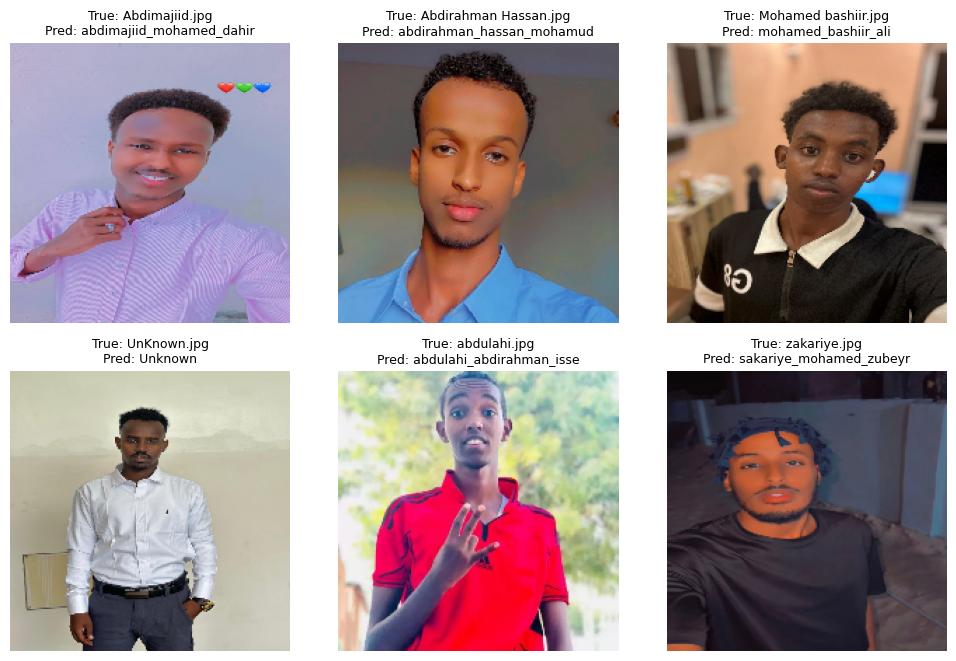

In [1]:
import os
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt
from insightface.app import FaceAnalysis
from sklearn.preprocessing import LabelEncoder

# Setup ArcFace
app = FaceAnalysis(name='antelopev2', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

# Load SVM model
model_path = 'svm_face_recognition_model_v3.joblib'
data_dir = 'data/preprocessed'  # should contain folders: PersonA/, PersonB/, etc.
classifier = joblib.load(model_path)
class_names = sorted(os.listdir(data_dir))

# Encode class names to match predictions
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

def get_embedding(img):
    faces = app.get(img)
    if not faces:
        return None
    return faces[0]['embedding']

def predict_face(image_path, classifier, class_names, threshold=0.3):
    img = cv2.imread(image_path)
    if img is None:
        return "Error"
    embedding = get_embedding(img)
    if embedding is None:
        return "No face"
    
    if hasattr(classifier, "predict_proba"):
        probabilities = classifier.predict_proba([embedding])[0]
        confidence = np.max(probabilities)
        if confidence < threshold:
            return "Unknown"
        predicted_idx = np.argmax(probabilities)
    else:
        distances = classifier.decision_function([embedding])[0]
        confidence = np.max(distances)
        if confidence < threshold:
            return "Unknown"
        predicted_idx = np.argmax(distances)
    
    return class_names[predicted_idx]

# ========== 🎯 MAIN PREDICTION AND VISUALIZATION ==========
# Set your test image directory
test_folder = r'C:\Users\abdirahman\Downloads\test'

image_files = sorted(os.listdir(test_folder))[:9]  # First 9 images for 3x3 grid

# Store labels
true_labels = []
predicted_labels = []

# Infer true label from folder or filename
for filename in image_files:
    true_label = filename.split("_")[0]  # assumes filenames like "PersonA_01.jpg"
    image_path = os.path.join(test_folder, filename)
    predicted_label = predict_face(image_path, classifier, class_names, threshold=0.3)
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# ========== 🖼️ DISPLAY GRID ==========
plt.figure(figsize=(10, 10))
for i in range(len(image_files)):
    img = cv2.imread(os.path.join(test_folder, image_files[i]))
    img = cv2.resize(img, (200, 200))  # Resize to fixed width and height
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}", fontsize=9)
    plt.axis('off')


plt.tight_layout()
plt.savefig("experiment_1_outputs.png")
plt.show()
